In [1]:
import healpy as hp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import uproot
from autogluon.tabular import TabularPredictor
from astropy import units as u
from astropy.coordinates import EarthLocation, SkyCoord
from astropy.time import Time
from getS50 import getS50

from scipy.stats import poisson
from scipy.optimize import minimize
from optimparallel import minimize_parallel
from tqdm.notebook import tqdm

In [2]:
def corrdinateToYBJ(Ra, Dec, mjd):
    """Transform J2000 to YBJ ALTAZ

    Args:
        Ra (np.array): Ra in J2000
        Dec (np.array): Dec in J2000
        mjd (np.array): mjd
    Returns:
        np.array: List of fo8ur np.array, first is theta with degree, second is phi with degree
    """
    YBJ_Location = EarthLocation(
        lat=30.102 * u.deg, lon=90.522 * u.deg, height=4300 * u.m
    )
    mjdtime = Time(mjd, format="mjd", location=YBJ_Location)
    newAltAzcoordiantes = SkyCoord(
        ra=Ra * u.deg,
        dec=Dec * u.deg,
        obstime=mjdtime,
        frame="icrs",
        location=YBJ_Location,
    )
    # LST = mjdtime.sidereal_time("apparent").degree
    alt = newAltAzcoordiantes.altaz.alt.degree
    az = newAltAzcoordiantes.altaz.az.degree
    return [
        90 - alt,
        az,
    ]

In [3]:
# 计算J1857视场中时间
number = 100000
mjd = np.linspace(56710, 56715, number)
theta, phi = corrdinateToYBJ(0, 2.5, mjd)
time_rate = np.sum(theta < 60) / number

In [4]:
NSIDE = 2**9
NPIX = hp.nside2npix(NSIDE)
isgamma_bin = [0.1, 0.2, 0.4, 0.6, 0.8, 0.9, 0.95, 0.97, 0.98, 0.99]
Energybin = np.logspace(1.2, 2.2, 6)
priEnergybin = np.logspace(0.6, 4, 18)
Energycenter = 10 ** ((np.log10(Energybin[1:]) + np.log10(Energybin[:-1])) / 2)

In [5]:
# 读取mc数据，用于计算PSF
MCdata = uproot.open("/home2/hky/github/Gamma_Energy/MCdata/data_gamma_026/RESULT.root")

In [6]:
paraneed = [
    "nch",
    "inout",
    "theta",
    "phi",
    "sigma",
    "cx",
    "cy",
    "sumpf",
    "summd",
    "mr1",
    "ne",
    "age",
    "pritheta",
    "priphi",
    "prie",
]

In [7]:
MCdata = MCdata["asresult"].arrays(paraneed, library="np")
MCdata["S50"] = getS50(MCdata["ne"], MCdata["age"])
MCdatacuted = np.where(
    (MCdata["nch"] >= 16)
    & (MCdata["sigma"] < 1)
    & (MCdata["inout"] == 1)
    & (MCdata["age"] > 0.301)
    & (MCdata["age"] < 1.599)
    & ((MCdata["summd"] < 0.4) | (MCdata["summd"] < 1.2e-3 * MCdata["sumpf"] ** 1.6))
    & (MCdata["theta"] < 60)
    & (MCdata["sumpf"] > 10**2.2)
)

MCdata = {key: MCdata[key][MCdatacuted] for key in MCdata.keys()}
MCdata["pritheta"] = np.rad2deg(MCdata["pritheta"])
MCdata["priphi"] = np.rad2deg(MCdata["priphi"])
MCdata["priphi"] = 180 - MCdata["priphi"]
MCdata["priphi"][MCdata["priphi"] > 180] = (
    MCdata["priphi"][MCdata["priphi"] > 180] - 360
)
MCdata["prie"] = MCdata["prie"] / 1000

In [8]:
# 读取之前的模型
Pgamma_high_predictor = TabularPredictor.load("./autogloun_model/highEnergy_fewcolumn/")
Energy_high_predictor = TabularPredictor.load("./autogloun_model/highEnergy_Energy")
deltatheta_high_predictor = TabularPredictor.load(
    "./autogloun_model/highEnergy_deltatheta/"
)
deltaphi_high_predictor = TabularPredictor.load(
    "./autogloun_model/highEnergy_deltaphi/"
)

In [9]:
# 做新的cut以及角度修正
MCdata_df = pd.DataFrame(MCdata)
for para in ["ne", "S50", "sumpf"]:
    MCdata_df[para] = np.log10(MCdata_df[para])
MCdata["isgamma"] = Pgamma_high_predictor.predict_proba(MCdata_df)[1].to_numpy()
MCdata["energy"] = 10 ** Energy_high_predictor.predict(MCdata_df).to_numpy() / 1000
MCdata["newtheta"] = (
    MCdata["theta"] - deltatheta_high_predictor.predict(MCdata_df).to_numpy()
)
MCdata["newphi"] = MCdata["phi"] - deltaphi_high_predictor.predict(MCdata_df).to_numpy()

In [10]:
MCdata["energy"]

array([ 52.69991 , 247.43805 , 287.9703  , ..., 199.39404 , 227.75362 ,
        22.188942], dtype=float32)

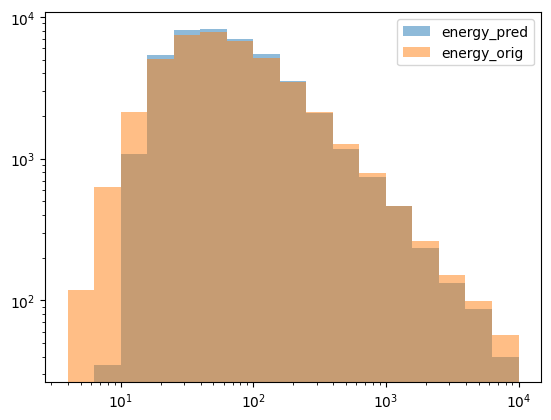

In [15]:
hist_pred=plt.hist(MCdata["energy"], alpha=0.5, bins=priEnergybin, label="energy_pred")
hist_orig=plt.hist(MCdata["prie"], alpha=0.5, bins=priEnergybin, label="energy_orig")
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.show()

/tmp/ipykernel_1983636/382069704.py:1: RuntimeWarning: divide by zero encountered in divide
  plt.plot((hist_orig[1][1:]+hist_orig[1][:-1])/2,hist_orig[0]/hist_pred[0])


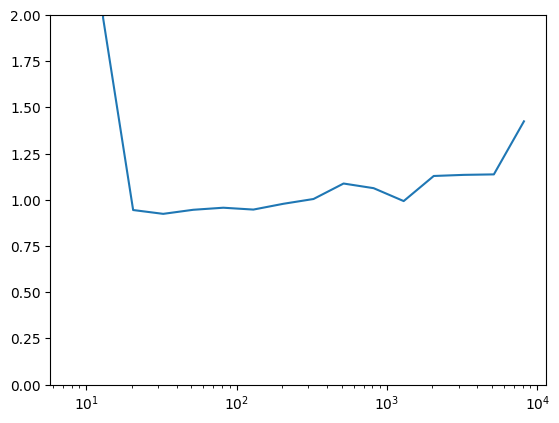

In [23]:
plt.plot((hist_orig[1][1:]+hist_orig[1][:-1])/2,hist_orig[0]/hist_pred[0])
plt.xscale("log")
plt.ylim(0,2)
plt.show()


In [24]:
PSF = np.zeros([len(isgamma_bin), len(Energybin) - 1, 100000])
b = np.linspace(0, np.pi, 100000 + 1)

In [25]:
# 计算每一个事例的角度差
distance = hp.rotator.angdist(
    hp.ang2vec(np.deg2rad(MCdata["newtheta"]), np.deg2rad(MCdata["newphi"])),
    hp.ang2vec(np.deg2rad(MCdata["pritheta"]), np.deg2rad(MCdata["priphi"])),
)

In [26]:
for i in range(len(isgamma_bin)):
    for j in range(len(Energybin) - 1):
        PSF[i, j], _ = np.histogram(
            distance[
                np.where(
                    (MCdata["isgamma"] > isgamma_bin[i])
                    & (MCdata["energy"] > Energybin[j])
                    & (MCdata["energy"] < Energybin[j + 1])
                )
            ],
            bins=b,
        )

In [27]:
beam = np.zeros([len(isgamma_bin), len(Energybin) - 1, 3 * NSIDE])
for i in tqdm(range(len(isgamma_bin))):
    for j in range(len(Energybin) - 1):
        beam[i, j] = hp.sphtfunc.beam2bl(
            PSF[i, j] / (b[1:] ** 2 - b[:-1] ** 2) / np.pi,
            (b[:-1] + b[1:]) / 2,
            NSIDE * 3 - 1,
        )

  0%|          | 0/10 [00:00<?, ?it/s]

In [28]:
# 计算响应矩阵
response = np.zeros([len(isgamma_bin), len(Energybin) - 1, len(priEnergybin) - 1])
for i in tqdm(range(len(isgamma_bin))):
    for j in range(len(priEnergybin) - 1):
        response[i, :, j], _ = np.histogram(
            MCdata["energy"][
                (MCdata["prie"] > priEnergybin[j])
                & (MCdata["prie"] < priEnergybin[j + 1])
                & (MCdata["isgamma"] > isgamma_bin[i])
            ],
            bins=Energybin,
        )
    prie_hist, _ = np.histogram(
        MCdata["prie"][(MCdata["isgamma"] > isgamma_bin[i])], bins=priEnergybin
    )
    response[i, :, :] = response[i, :, :] / prie_hist
response[np.isnan(response)] = 0

  0%|          | 0/10 [00:00<?, ?it/s]

/tmp/ipykernel_1983636/3796542367.py:16: RuntimeWarning: invalid value encountered in divide
  response[i, :, :] = response[i, :, :] / prie_hist


In [29]:
# 测试一下响应矩阵
for i in tqdm(range(len(isgamma_bin))):
    energy_hist, _ = np.histogram(
        MCdata["energy"][(MCdata["isgamma"] > isgamma_bin[i])], bins=Energybin
    )
    prie_hist, _ = np.histogram(
        MCdata["prie"][(MCdata["isgamma"] > isgamma_bin[i])], bins=priEnergybin
    )
    print(energy_hist / np.matmul(response[i], prie_hist))

  0%|          | 0/10 [00:00<?, ?it/s]

[1.00057593 1.         1.         1.         1.        ]
[1.00059055 1.         1.         1.         1.        ]
[1.00060926 1.         1.         1.         1.        ]
[1.00062539 1.         1.         1.         1.        ]
[1.0004787 1.        1.        1.        1.       ]
[1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1.]


In [30]:
# 读入pri数据，计算效率
pridata = uproot.open(
    "/home2/hky/github/Gamma_Energy/MCdata/data_gamma_026/priall.root"
)
pridata = pridata["tpri"].arrays(pridata["tpri"].keys(), library="np")

In [31]:
priorg_hist, _ = np.histogram(pridata["e"] / 1000, bins=priEnergybin)
eta = np.zeros([len(isgamma_bin), len(priEnergybin) - 1])
for i in tqdm(range(len(isgamma_bin))):
    prie_hist, _ = np.histogram(
        MCdata["prie"][(MCdata["isgamma"] > isgamma_bin[i])], bins=priEnergybin
    )
    eta[i] = prie_hist / priorg_hist

  0%|          | 0/10 [00:00<?, ?it/s]

In [32]:
# 清内存
del MCdata
del pridata

In [33]:
# 定义模型
class sourcemodel:
    def __init__(
        self,
        response,
        eta,
        isgamma_i,
        beam,
        T=719.15 * time_rate * 24 * 60 * 60,
        area=30000 * 30000 * 3.1415926,
        spectrumfunction="Cutoff_powerlaw",
        spacefunction="disksource",
        **args
    ) -> None:
        if spectrumfunction == "Cutoff_powerlaw":
            self.spectrumfunction = self.Cutoff_powerlaw
        if spectrumfunction == "powerlaw":
            self.spectrumfunction = self.powerlaw
        if spacefunction == "disksource":
            self.spacefunction = self.disksource
        self.response = response[isgamma_i]
        self.eta = eta[isgamma_i]
        self.isgamma_i = isgamma_i
        self.T = T
        self.area = area
        self.energybin = priEnergybin
        self.energybincenter = 10 ** (
            (np.log10(self.energybin[:-1]) + np.log10(self.energybin[1:])) / 2
        )
        self.obenergybin = Energybin
        self.beam = beam

        if "K" in args:
            self.K = args["K"]
        if "index" in args:
            self.index = args["index"]
        if "E_cut" in args:
            self.E_cut = args["E_cut"]
        else:
            self.E_cut = None
        if "Ra" in args:
            self.Ra = args["Ra"]
        if "Dec" in args:
            self.Dec = args["Dec"]
        if "sourcetype" in args:
            self.sourcetype = args["sourcetype"]
        if "radius" in args:
            self.radius = args["radius"]
        else:
            self.radius = None

    def Cutoff_powerlaw(self, x, K, index, E_cut):
        return 10**K * (x / 1) ** index * np.exp(-x / E_cut)

    def powerlaw(self, x, K, index, E_cut):
        return 10**K * (x / 1) ** index

    def disksource(self, Ra, Dec, sourcetype="point", radius=None):
        if sourcetype == "point":
            pix = hp.ang2pix(NSIDE, Ra, Dec, lonlat=True)
            return [pix]
        elif sourcetype == "extend":
            pix = hp.query_disc(
                NSIDE,
                hp.ang2vec(Ra, Dec, lonlat=True),
                radius=np.radians(radius),
            )
            return pix

    def getmap_beforePSF(self):
        hp_map = np.zeros([len(self.obenergybin) - 1, NPIX])
        for i in range(len(self.obenergybin) - 1):
            hp_map[i][
                self.spacefunction(self.Ra, self.Dec, self.sourcetype, self.radius)
            ] = 1
        return hp_map

    def getmap(self):
        hp_map = self.getmap_beforePSF()
        hp_map[np.isnan(hp_map)] = 0
        for i in range(self.beam[self.isgamma_i].shape[0]):
            hp_map[i] = hp.smoothing(
                hp_map[i], beam_window=self.beam[self.isgamma_i, i]
            )
        return hp_map

    def cal_base_map(self):
        self.smooth_map = self.getmap()

    def cal_map(self, par):
        self.K, self.index, self.E_cut = par
        hp_map = np.zeros([len(self.obenergybin) - 1, NPIX])
        org_number = np.zeros(len(self.energybincenter))
        for i in range(len(self.energybincenter)):
            org_number[i] = (
                self.spectrumfunction(
                    self.energybincenter[i], self.K, self.index, self.E_cut
                )
                * self.T
                * self.area
                * (self.energybin[i + 1] - self.energybin[i])
            )
        ob_number = np.matmul(self.response, self.eta * org_number)
        for i in range(len(self.smooth_map)):
            if np.sum(self.smooth_map[i]) != 0:
                hp_map[i] = (
                    self.smooth_map[i] / np.sum(self.smooth_map[i]) * ob_number[i]
                )
        return hp_map

In [39]:
# 读取之前做的所有数据和Background
All = np.load("./All.npy")[:,3:8,:]
Background = np.load("./Background.npy")[:,3:8,:]

In [46]:
def getmaxlikehood(isgamma_i):
    par0 = [-1.110e01, 1.100e01, -1.231e01]
    bounds = [
        (-15, -10),
        (0.1, 2000),
        (-15, -10),
    ]
    J1857 = sourcemodel(
        response,
        eta,
        isgamma_i,
        beam,
        Ra=284.34,
        Dec=2.76,
        sourcetype="extend",
        radius=0.26,
        K=par0[0],
        index=-2.15,
        E_cut=par0[1],
    )
    J1857.cal_base_map()
    J1858 = sourcemodel(
        response,
        eta,
        isgamma_i,
        beam,
        Ra=284.57,
        Dec=2.06,
        sourcetype="point",
        spectrumfunction="powerlaw",
        K=par0[2],
        index=-2.11,
    )
    J1858.cal_base_map()
    def log_prob(par):
        par_J1857 = [par[0], -2.15, par[1]]
        par_J1858 = [par[2], -2.06, None]

        J1857_map = J1857.cal_map(par_J1857)
        J1858_map = J1858.cal_map(par_J1858)
        All_map = J1857_map + J1858_map
        #     print(np.sum(All_map))
        #     print(All_map.shape)
        pix_need = hp.query_disc(NSIDE, hp.ang2vec(284.5, 2.5, lonlat=True), np.deg2rad(4))
        All_map[All_map < 0] = 0
        #     print(Background[isgamma_i][:, pix_need].shape)
        pre = Background[isgamma_i][:, pix_need] + All_map[:, pix_need]
        prob = poisson.pmf(All[isgamma_i][:, pix_need], pre)
        # return prob
        if np.any(prob == 0):
            return -np.inf
#         print(np.sum(np.log(prob)))
        return np.sum(np.log(prob))


    def log_prob0():
        pix_need = hp.query_disc(NSIDE, hp.ang2vec(284.5, 2.5, lonlat=True), np.deg2rad(4))
        prob = poisson.pmf(All[isgamma_i][:, pix_need], Background[isgamma_i][:, pix_need])
        # return prob
        if np.any(prob == 0):
            return -np.inf
        return np.sum(np.log(prob))


    def neg_log_prob(par):
        return -log_prob(par)
    res = minimize(neg_log_prob, par0, bounds=bounds)
    print(isgamma_i, res.x)
    print(res.fun, 2 * (-res.fun - log_prob0()))

In [47]:
for isgamma_i in range(10):
    getmaxlikehood(isgamma_i)

0 [-11.76535489 155.98712426 -12.12046104]
25833.89194311455 56.78944974305341
1 [-12.00638321 302.78513328 -12.29159888]
21211.636279168033 38.89299116476468
2 [-12.21191162 391.92650868 -12.2909648 ]
16421.2082062887 40.11941136961832
3 [-12.07715792  89.60283689 -12.38480473]
13516.84840483724 35.28528643133541
4 [-11.9506891   34.7958286  -12.41113773]
10287.208144617083 32.832997265231825
5 [-12.12958536  36.09523518 -12.560715  ]
7065.389026652347 21.52168371850894
6 [-10.           3.25261036 -12.51648756]
3466.5167476340794 26.30966104617619
7 [-15.          10.59004614 -12.64043293]
1930.7246297790807 18.006898108052155
8 [-15.          10.67631573 -12.8340253 ]
1246.632651692896 8.536319872982403
9 [-15.          10.70820497 -12.93911133]
612.711309182122 5.688836217747394
